# AGAR Workshop 2022

# Module 3: Introduction to msprime

Let's load the packages we will need.

In [1]:
import msprime
import numpy as np
import tskit
from IPython.display import SVG, display

# Ancestry Simulations

Start with sim_ancestry function. No mutations. No complex demography. Just a simple gene genealogy.

Let's start with one sample. We will run the simulation and examine the tree sequence object.

In [2]:
ts1 = msprime.sim_ancestry(1)
ts1

Let's draw the tree.

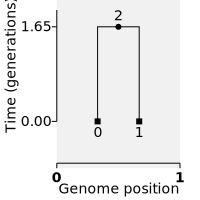

In [3]:
SVG(ts1.draw_svg(y_axis = True))

We can call various attributes on this object as well.

Sequence length.

In [4]:
ts1.sequence_length

1.0

The number of haploid samples.

In [5]:
ts1.num_samples

2

The number of trees.

In [6]:
ts1.num_trees

1

The number of sites. This should be 0 because we have not added any mutations yet.

In [7]:
ts1.num_sites

0

What happens if we run the exact same simulation again?

In [8]:
ts2 = msprime.sim_ancestry(1)
ts2

**Question:** Has the table changed?

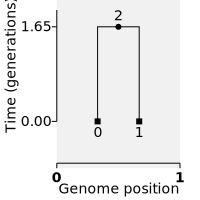

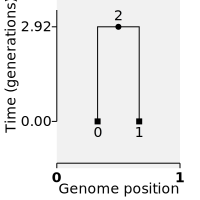

In [9]:
display(SVG(ts1.draw_svg(y_axis = True)), SVG(ts2.draw_svg(y_axis = True)))

**Question:** What about the tree? What has changed?

## Random Seeds

We can use a random seed to make our analyses replicable. Briefly, this 'seed' is used as the starting point for a random number generator. The specific number does not matter so feel free to choose any value.

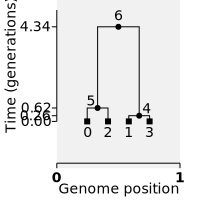

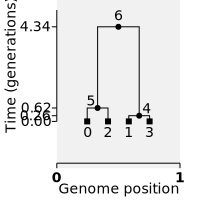

In [10]:
ts1 = msprime.sim_ancestry(2, random_seed=100)
ts2 = msprime.sim_ancestry(2, random_seed=100)
display(SVG(ts1.draw_svg(y_axis=True)), SVG(ts2.draw_svg(y_axis=True)))

We'll come back to random seeds when we add mutations and implement more complex demographic models later! I'll start using random seeds in this notebook so that you can reproduce these results but please do tinker with these seeds to view different genealogies.

## Varying TMRCA

Using one of our ancestries, let's get the time to most recent common ancestor (TMRCA).

We can access a specific tree in our tree sequence object using the following code. This may seem odd now but by the end of this module you will have ts objects with multiple trees.

In [11]:
ts = msprime.sim_ancestry(1, random_seed = 200)

In [12]:
ts.first()

You may not be surprised to learn there is a .last() function as well. It should return the same tree because we have one tree.

In [13]:
ts.last()

Alternatively, we can use the index. Remember that Python indexing starts at 0!

In [14]:
ts.at_index(0)

Now call the .tmrca() function on the specific tree. Note that two positional argument are required: the nodes for which we want to know the TMRCA.

In [15]:
ts.first().tmrca(0,1)

5.8989290225478985

We can also get the identity of that node using the .mrca() function.

In [16]:
ts.first().mrca(0,1)

2

**Question**: If the average pair of genes shared a common ancestor 2N generations ago, what should the TMRCA be for a sample with one diploid?

Let's write a function to repeat this simulation a number of times and get the mean TMRCA across all our replicates.

In [17]:
def one_sample_generation_mean(num_reps):
    N = num_reps
    t_mrca = np.zeros(N)
    replicates = msprime.sim_ancestry(1, num_replicates = N)
    for i, ts in enumerate(replicates):
        t_mrca[i] = ts.first().tmrca(0,1)
    return np.mean(t_mrca)

Functions are an essential part of bioinformatics and enable mass repitition of certain analyses. Here we define a function that will run an msprime simulation for one diploid N times. We will collect the TMRCA per replicate in a list.

In [18]:
one_sample_generation_mean(10)

3.4446084991078294

In [19]:
one_sample_generation_mean(100)

1.7745553747624414

In [20]:
one_sample_generation_mean(1000)

1.9512507229674165

In [21]:
one_sample_generation_mean(10000)

2.031839095909965

**Question**: What happened to the TMRCA as you add replicates? Why?

**Question**: Given that TRMCA in generations = 2N, how many generations (on average) would you have to go back to find the MRCA in a population of 1200 individuals? 5000 individuals?

How much time does it take to run these simulations? Let modify our function to not only return us the mean TMRCA but the time needed to execute the function.

In [22]:
import time

In [23]:
def one_sample_generation_mean(num_reps):
    time_start = time.time()
    N = num_reps
    t_mrca = np.zeros(N)
    replicates = msprime.sim_ancestry(1, num_replicates = N)
    for i, ts in enumerate(replicates):
        t_mrca[i] = ts.first().tmrca(0,1)
    time_end = time.time()
    total_time = time_end - time_start
    return np.mean(t_mrca), total_time

Run this with an increasing number of replicates.

In [24]:
one_sample_generation_mean(10)

(1.9326359263567763, 0.0033881664276123047)

In [25]:
one_sample_generation_mean(100)

(1.8695394467467403, 0.007854223251342773)

In [26]:
one_sample_generation_mean(1000)

(2.0365863846622396, 0.05294322967529297)

In [27]:
one_sample_generation_mean(10000)

(2.004546909953981, 0.4829528331756592)

**Question**: How is time scaling with the number of replicates?

## Increased Sample Size

Let's increase the sample size.

Note that I'm going to add some arguments to the .draw_svg function to make viewing the tree a bit easier. 

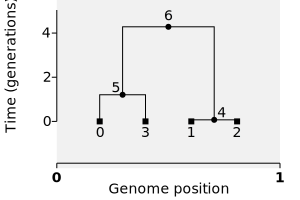

In [28]:
ts = msprime.sim_ancestry(2, random_seed = 1234)
SVG(ts.draw_svg(size=(300,200), y_axis = True, y_ticks=[0,2,4]))

## Saving Tree Plots

Increase the sample size again and save the drawing as an object. Then call SVG() on the object. Let's learn how to save these plots.

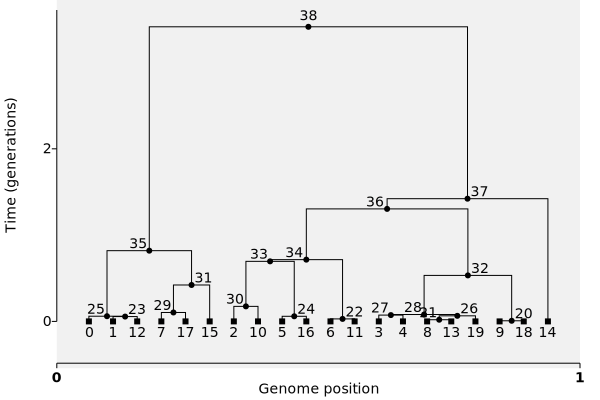

In [29]:
ts = msprime.sim_ancestry(10, random_seed = 5678)
ts_plot = ts.draw_svg(size=(600,400), y_axis = True, y_ticks=[0,2,4])
SVG(ts_plot)

What a beautiful simulation. It's unlikely that such simulations will be a main figure in a manuscript but they may be useful in a presentation or in the supplement.

We save the same way we would in any general Pythonic sense.

In [30]:
with open('msprime_ts_plot.svg', 'w') as svg_file:
        svg_file.write(ts_plot)

## Ploidy

msprime defaults to diploid but one can specify the ploidy with the ploidy argument in ancestry simulations. If we increase from 2 to 3 there should be 50% more nodes in our simulation.

In [31]:
ts = msprime.sim_ancestry(10, ploidy = 3, random_seed = 787)
ts

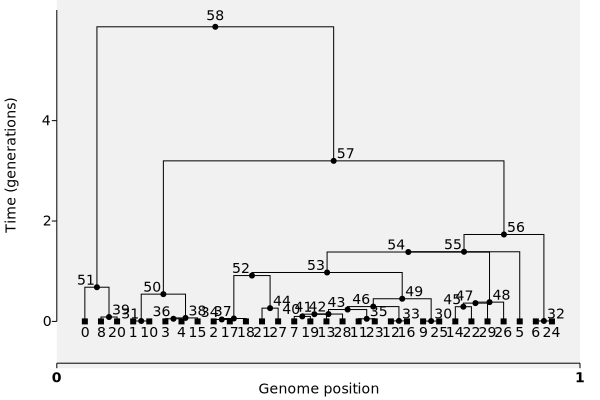

In [32]:
SVG(ts.draw_svg(size=(600,400), y_axis = True, y_ticks=[0,2,4]))

## Population Size

We can also specify the size of the population from which samples are drawn. We code this using the population size argument.

**Question:** What effect should this have on generation time if the population size increases?

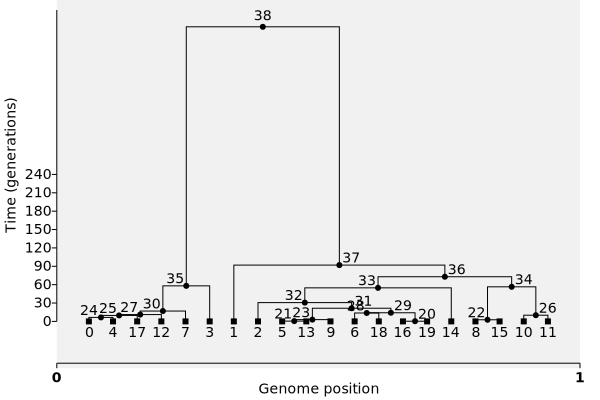

In [33]:
ts = msprime.sim_ancestry(10, population_size = 100, random_seed = 456)
SVG(ts.draw_svg(size=(600,400), y_axis = True, y_ticks=[0,30,60,90,120,150,180,210,240]))

## Genome Properties

Thus far we have not defined the sequence length nor needed to. But this is easily added.

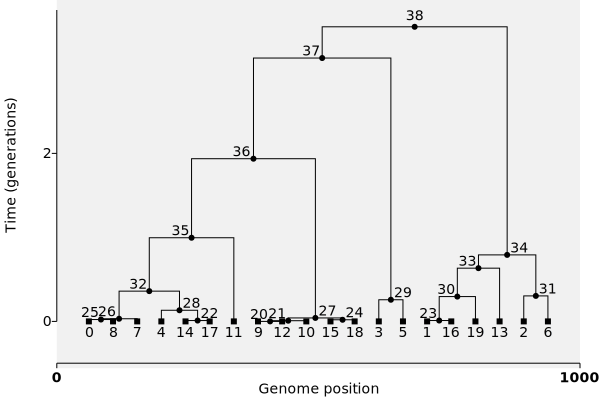

In [34]:
ts = msprime.sim_ancestry(10, sequence_length = 1000, random_seed = 9)
SVG(ts.draw_svg(size=(600,400), y_axis = True, y_ticks=[0,2,4]))

Sequence length does not matter to a genealogy in the absence of two forces: 1) recombination and 2) mutation. We'll tackle recombination first and dedicate an entire section to mutation.

We add the recombination_rate argument to our ancestry simulation. Let's downsize our sample a bit too to fit everything in one plot.

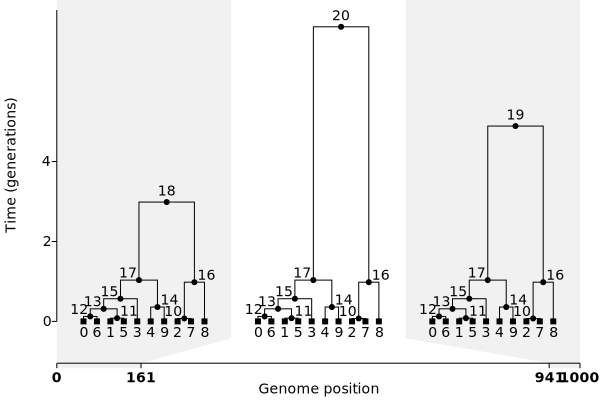

In [35]:
ts = msprime.sim_ancestry(5, recombination_rate = 0.0001, sequence_length = 1000, random_seed = 9999)
SVG(ts.draw_svg(size=(600,400), y_axis = True, y_ticks=[0,2,4]))

Decrease the sample size again and increase the rate.

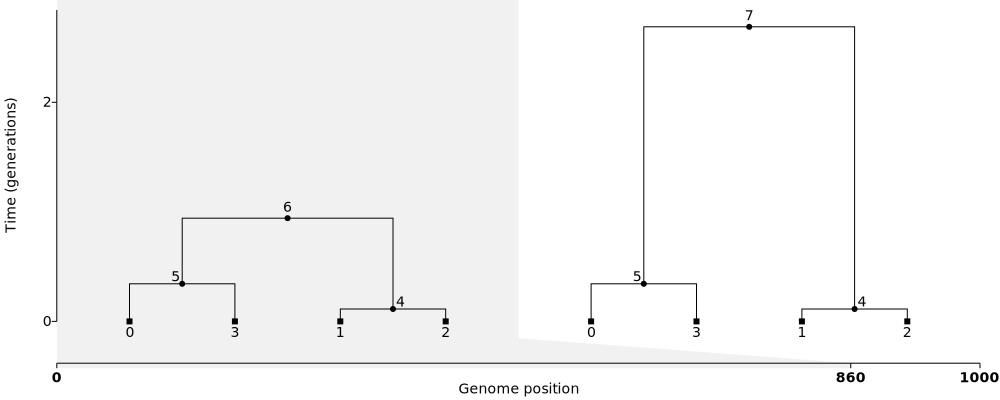

In [36]:
ts = msprime.sim_ancestry(2, recombination_rate = 0.001, sequence_length = 1000, random_seed = 5285)
SVG(ts.draw_svg(size=(1000,400), y_axis = True, y_ticks=[0,2,4]))

We can also specify a recombination map by defining a rate map. Note that once need not include sequence length in the ancestry simulation but, if you do, ensure that it matches the rate map!

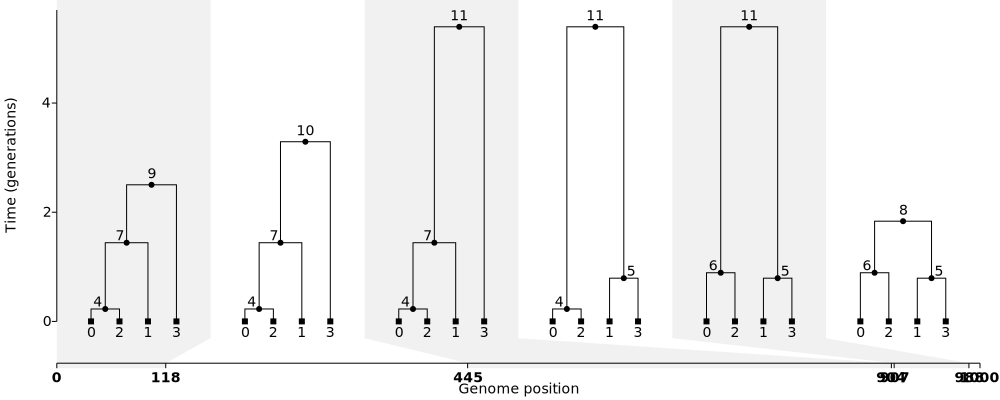

In [37]:
rate_map = msprime.RateMap(position=[0, 120, 860, 1000], rate=[0.001, 0.0001, 0.002])
ts = msprime.sim_ancestry(2, recombination_rate = rate_map, sequence_length = 1000, random_seed = 12045)
SVG(ts.draw_svg(size=(1000,400), y_axis = True, y_ticks=[0,2,4]))

The above commands should allow you to simulate a variety of genealogies. Now let's add some additional complexity: mutations.

# Mutation Simulation

We can apply mutations to an ancestry object using the .sim_mutations() function. There are a couple of potential arguments but let's start with the 1) ancestry object and a 2) the mutation rate. Note that we've also added a sequence length argument to our ancestry simulation.

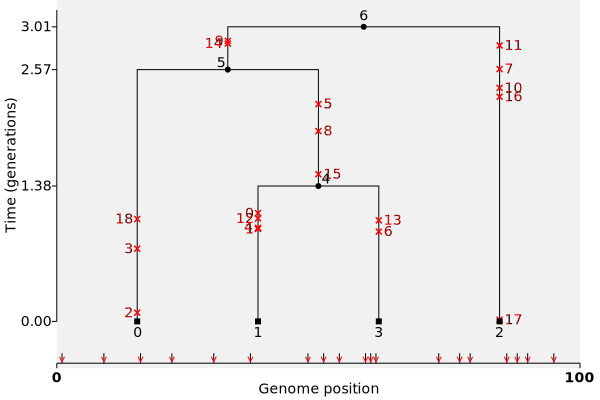

In [38]:
ts = msprime.sim_ancestry(2, sequence_length = 100, random_seed = 56)
mts = msprime.sim_mutations(ts, rate=0.01, random_seed = 325)
SVG(mts.draw_svg(size=(600,400), y_axis = True))

Now let's vary the mutation rate along the sequence. We will add a rate map just like we did for recombination.

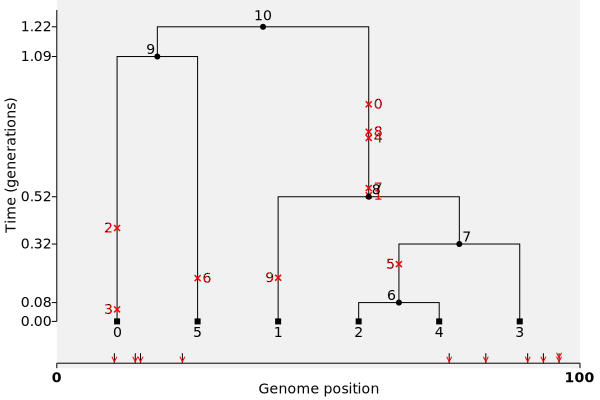

In [39]:
ts = msprime.sim_ancestry(3, sequence_length = 100, random_seed = 520)
ratemap = msprime.RateMap(position=[0, 45, 62, 100], rate=[0.02, 0.001, 0.03])
mts = msprime.sim_mutations(ts, rate=ratemap, random_seed = 1002)
SVG(mts.draw_svg(size=(600,400), y_axis = True))

**Question**: Why would one need a mutation rate map for simulations?

**Question**: You will need some justification for the chosen mutation rate in your simulation, which often comes from the literature. There are often a range of rates to choose from in a single species. What might cause variable mutation rate estimates for the same population?

### Accessing Variant Information and Statistics

When we simulate mutations, we are often after the allele frequencies/genotypes at these loci. We can use the .variants() function to retrieve this information.

In [40]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep='\t')

11.0	('G', 'A')	[0 1 1 1 1 0]
15.0	('T', 'C')	[0 1 1 1 1 0]
16.0	('A', 'T')	[1 0 0 0 0 0]
24.0	('T', 'G')	[1 0 0 0 0 0]
75.0	('C', 'T')	[0 1 1 1 1 0]
82.0	('C', 'T')	[0 0 1 0 1 0]
90.0	('A', 'G')	[0 0 0 0 0 1]
93.0	('C', 'A')	[0 1 1 1 1 0]
96.0	('A', 'C', 'G')	[0 2 1 1 1 0]


**Question:** What do the 0s and 1s mean in the genotype array? Do you have any sites with more than two alleles listed?

Let's calculate some statistics. Many of these are built into msprime/tskit! However, if you don't see what you need or want to tinker with a particular statistic, you can easily write a function and apply it to the variant data.

One useful statistic is the density of segregating sites. We can calculate this using the .segregating_sites() function. 

In [41]:
mts.segregating_sites()

array(0.1)

Now for sample heterozygosity or pi (Nei and Li (1979)).

In [42]:
mts.diversity()

array(0.044)

We can also calculate this in windows.

In [43]:
windows = np.linspace(0, ts.sequence_length, num = 5)
d = mts.diversity(windows = windows)
print(windows, d, sep = '\n')

[  0.  25.  50.  75. 100.]
[0.06933333 0.         0.         0.10666667]


Let's try something a little more complicated. Recombination is often highest in the distal regions of the chromosome (furthest away from the centromere, which is usually near the center). Write a simulation whose sequence length is at least 10,000 bp, implement a recombination map that captures this general recombination pattern, and calculate pi in 1,000 bp windows. Feel free to tinker with the number of samples, the recombination rate, and the mutation rate.  

In [44]:
windows = [0,100,200,300,400,500,600,700,800,900,1000]
rate_map = msprime.RateMap(position=[0, 120, 860, 1000], rate=[0.1, 0.0001, 0.2])
ts = msprime.sim_ancestry(3, sequence_length = 1000, recombination_rate = rate_map, random_seed = 520)
mts = msprime.sim_mutations(ts, rate = 0.1, random_seed = 1002)
d = mts.diversity(windows = windows)
print(windows, d, sep = '\n')

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[0.27733333 0.21133333 0.18266667 0.14133333 0.14666667 0.106
 0.12466667 0.20066667 0.20866667 0.27333333]


# Demography Simulations

We know how to simulate ancestry and mutations. Let's model more realistic scenarios that involve sampling from a dynamic and/or multiple populations.

We can use the .Demography() function to create a demographic object and other commands to build the model. Here we will build a model with two extant populations (African (AFR) and Eurasian (EUR)) that share a common ancestor (AFR_EUR) 1000 generations ago. Note that we specify the derived and ancestral populations using their labels. We will sample one individual from each population.

In [45]:
demography = msprime.Demography()
demography.add_population(name = 'AFR', initial_size = 10000)
demography.add_population(name = 'EUR', initial_size = 5000)
demography.add_population(name = 'AFR_EUR', initial_size = 10000)
demography.add_population_split(time = 1000, derived = ['AFR', 'EUR'], ancestral = 'AFR_EUR')
ts = msprime.sim_ancestry(samples={'AFR': 1, 'EUR': 1}, demography = demography, random_seed = 6045)
ts

Let's look at the demography object. 

In [46]:
demography

Demography(populations=[Population(initial_size=10000, growth_rate=0, name='AFR', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=5000, growth_rate=0, name='EUR', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=10000, growth_rate=0, name='AFR_EUR', description='', extra_metadata={}, default_sampling_time=1000, initially_active=False, id=2)], events=[PopulationSplit(time=1000, derived=['AFR', 'EUR'], ancestral='AFR_EUR')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

Note that we even get links to the type of events in our model. These links will send you to the msprime documentation.

Run .debug() on the demography object.

In [47]:
demography.debug()

**Question:** What additional information is displayed with .debug()?

Draw the sequence.

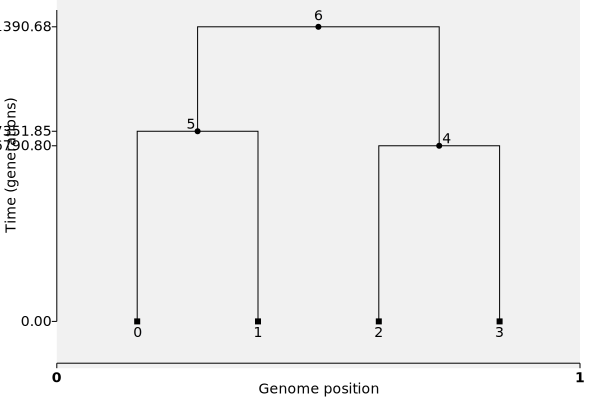

In [48]:
SVG(ts.draw_svg(size=(600,400), y_axis = True))

Repeat the model above but add a sequence length and a low mutation rate. **I suggest using a rate >= 1e-7 (0.0000001) to prevent your notebook from freezing up.** Draw your tree.

In [49]:
ts = msprime.sim_ancestry(samples={'AFR': 1, 'EUR': 1}, demography = demography, sequence_length = 1000, random_seed = 6045)
mts = msprime.sim_mutations(ts, rate=0.0000001)

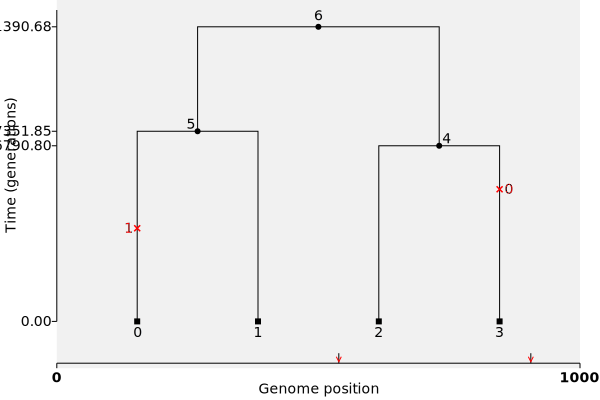

In [50]:
SVG(mts.draw_svg(size=(600,400), y_axis = True))

Let's look at the variants.

In [51]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep='\t')

539.0	('T', 'G')	[0 0 0 1]
906.0	('T', 'A')	[1 0 0 0]


If we wanted to look at a specific population's variant information, we can assign the node IDs to a population variable.

In [52]:
AFR = (0, 1)
EUR = (2, 3)

If you forget what nodes belong to which population, run the command below to examine all nodes in the tree.

In [53]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,b''
1,1,0,0,0.00000000,b''
2,1,1,1,0.00000000,b''
3,1,1,1,0.00000000,b''
4,0,2,-1,6790.79688883,b''
5,0,2,-1,7351.84606113,b''
6,0,2,-1,11390.67692681,b''


Specify the population and then print the variant information.

In [54]:
for var in mts.variants(samples = AFR):
    print(var.site.position, var.alleles, var.genotypes, sep='\t')

539.0	('T', 'G')	[0 0]
906.0	('T', 'A')	[1 0]


In [55]:
for var in mts.variants(samples = EUR):
    print(var.site.position, var.alleles, var.genotypes, sep='\t')

539.0	('T', 'G')	[0 1]
906.0	('T', 'A')	[0 0]


## Adding Demographic Events

Now for some more complex (and realistic) demographies. You'll tackle migration and admixture in the next module but let's talk about growth rates and bottlenecks briefly.

We can modify parameters in existing populations using the .add_population_parameters_change() function. This requires a couple of arguments: 1) time, 2) the population, and 3) the modified parameters.

In [56]:
demography.add_population_parameters_change(time = 10, population = 'EUR', growth_rate = 0.01)

PopulationParametersChange(time=10, initial_size=None, growth_rate=0.01, population='EUR')

If you add something out of order, you must use the .sort_events() function.

In [57]:
demography.sort_events()

Use the demography debugger to see our added growth rate.

In [58]:
demography.debug()

Let's consider bottlenecks. You can employ either instantaneous or simple bottlenecks in msprime. Let's try the first using a simple demography, as it is more useful for simulating real populations.

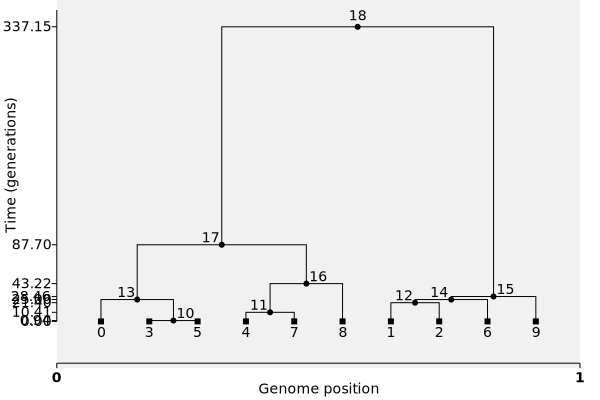

In [59]:
demography = msprime.Demography()
demography.add_population(initial_size = 100)
demography.add_instantaneous_bottleneck(time = 25, strength = 10, population = 0)

ts = msprime.sim_ancestry(5, demography = demography, random_seed = 1234)
SVG(ts.draw_svg(y_axis = True, size =(600, 400)))

When we simulate multiple populations, we are often interested in differences between them. In the next module, you will estimate a metric of population differentation called Fst. Let's do a quick preview here using msprime. Build the following three population model.

In [60]:
demography = msprime.Demography()
demography.add_population(name = 'ppn', initial_size = 18000)
demography.add_population(name = 'ptt', initial_size = 30000)
demography.add_population(name = 'ptv', initial_size = 15000)
demography.add_population(name = 'ptt_ptv', initial_size = 15000)
demography.add_population(name = 'ppn_ptt_ptv', initial_size = 20000)
demography.add_population_split(time = 20000, derived = ['ptt', 'ptv'], ancestral = 'ptt_ptv')
demography.add_population_split(time = 75200, derived = ['ppn', 'ptt_ptv'], ancestral = 'ppn_ptt_ptv')
ts = msprime.sim_ancestry(samples={'ppn': 5, 'ptt': 5, 'ptv': 5}, demography = demography, sequence_length = 1000000, random_seed = 6783)
mts = msprime.sim_mutations(ts, rate=1.25e-8, random_seed = 85296)
ts

Visualize.

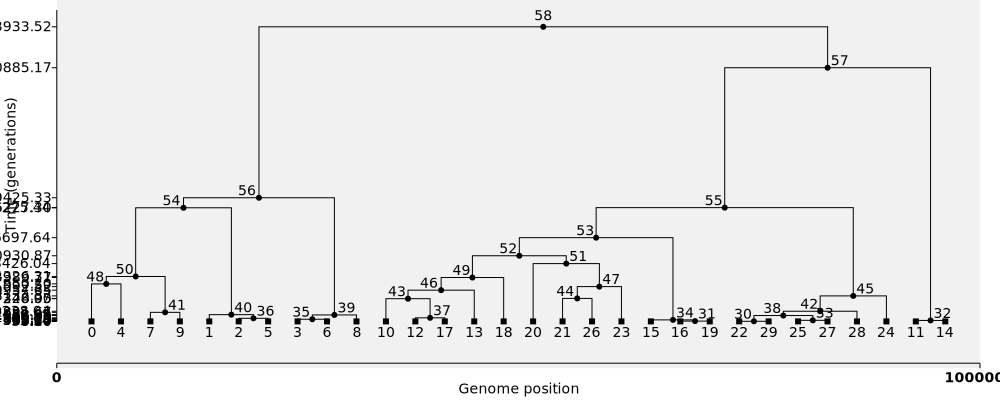

In [61]:
SVG(ts.draw_svg(y_axis = True, size =(1000, 400)))

Now let's calculate Fst between all pairs of populations. Check the index number of the populations. 

In [62]:
demography

Demography(populations=[Population(initial_size=18000, growth_rate=0, name='ppn', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=30000, growth_rate=0, name='ptt', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=15000, growth_rate=0, name='ptv', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=15000, growth_rate=0, name='ptt_ptv', description='', extra_metadata={}, default_sampling_time=20000, initially_active=False, id=3), Population(initial_size=20000, growth_rate=0, name='ppn_ptt_ptv', description='', extra_metadata={}, default_sampling_time=75200, initially_active=False, id=4)], events=[PopulationSplit(time=20000, derived=['ptt', 'ptv'], ancestral='ptt_ptv'), PopulationSplit(time=75200, derived=['ppn', 'ptt_ptv'], ancestral='ppn_ptt_ptv')], migration_matrix=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]))

Calculate Fst. Multiway statistics like Fst require specifying the sample sets.

In [63]:
mts.Fst(sample_sets=[ts.samples(population = 0), ts.samples(population = 1)])

array(0.45293132)

In [64]:
mts.Fst(sample_sets=[ts.samples(population = 0), ts.samples(population = 2)])

array(0.56574832)

In [65]:
mts.Fst(sample_sets=[ts.samples(population = 1), ts.samples(population = 2)])

array(0.1318674)

Fst can range from 0 to 1, where 0 reflects less population differentiation and 1 reflect more population differentiation. You should observe a lower value between the populations that diverged closer to the present and higher values between the populations that diverged deeper in the past. However, a lot of parameters can affect this metric. Note: sometimes you will get a negative Fst value. This is due to the bias correction in the Weir and Cockerham (1984) version of Fst that msprime uses. Treat such values as 0.

As aformentioned, you will tackle Fst in the next module so we will go into more detail shortly.

**Exercise:** Build a demographic model from scratch that meets the following criteria:
- at least three populations
- a population split that occurred >= 5000 generations
- sequence length of 1000
- a mutation rate and recombination rate

Plot your ancestry (no need to include the mutations) and calculate some statistic such as pi or Fst. I encourage you to try a statistic that we have not yet covered or write your own if you are comfortable doing so. 

Available statistics from tskit are described here: https://tskit.dev/tskit/docs/stable/stats.html#.

I also encourage you to build a model that is relevant to your own interests/research!

# Exporting / Reloading Results

## Tree Sequence Format

If you find yourself in need of exporting data in a tree sequence format, you can run the following command whose only argument in the file path.

In [66]:
ts.dump("my_tree_sequence.trees")

You can also load trees using the .load() function.

In [67]:
new_ts = tskit.load("my_tree_sequence.trees")

Let's make sure we loaded the correct file!

In [68]:
ts

In [69]:
new_ts

## Other Formats

Most often, we are interested in

# Replication

Very often, we want to compare a null distribution to some observed value(s). To do so, requires running lots of simulations. Generally, it's best to only store a single simulation in memory at a time and store the desired results in a list. To do so, we can write a function to do the ancestry simulation first and then a mutation simulation. We can define any variables whose value we probably won't tinker with inside the function. 

In [70]:
def sim_replicates(sample_size, num_replicates):
    ancestry_reps = msprime.sim_ancestry(
        samples = sample_size,
        population_size = 100, sequence_length = 1000,
        num_replicates = num_replicates)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate = 1e-6)
        yield mutated_ts

Other variables we can define before applying the function.

In [71]:
num_replicates = 100
S = np.zeros(num_replicates)
for replicate_index, ts in enumerate(sim_replicates(10, num_replicates)):
    S[replicate_index] = ts.segregating_sites(span_normalise = False, mode = 'site')

(np.mean(S), np.var(S))

(1.53, 1.8291)